<a href="https://colab.research.google.com/github/Jun-Jiang03/crude_oil_prediction/blob/main/WSC_price_percentage_change_vs_GDP_Spark_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 3: Retriveing the Model using Spark and model optimization

In [1]:
!wget https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar -xvzf spark-3.5.1-bin-hadoop3.tgz
!pip install findspark


--2025-03-02 03:10:40--  https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400446614 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.1-bin-hadoop3.tgz’

spark-3.5.1-bin-had 100%[===================>] 381.90M  29.3MB/s    in 14s     

2025-03-02 03:10:55 (27.2 MB/s) - ‘spark-3.5.1-bin-hadoop3.tgz’ saved [400446614/400446614]

spark-3.5.1-bin-hadoop3/
spark-3.5.1-bin-hadoop3/sbin/
spark-3.5.1-bin-hadoop3/sbin/spark-config.sh
spark-3.5.1-bin-hadoop3/sbin/stop-slave.sh
spark-3.5.1-bin-hadoop3/sbin/stop-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/start-workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-slaves.sh
spark-3.5.1-bin-hadoop3/sbin/start-all.sh
spark-3.5.1-bin-hadoop3/sbin/stop-all.sh
spark-3.5.1-bin-hadoop3/sbin/workers.sh


In [2]:
!ls -l spark-3.5.1-bin-hadoop3


total 156
drwxr-xr-x 2 1000 1000  4096 Feb 15  2024 bin
drwxr-xr-x 2 1000 1000  4096 Feb 15  2024 conf
drwxr-xr-x 6 1000 1000  4096 Feb 15  2024 data
drwxr-xr-x 4 1000 1000  4096 Feb 15  2024 examples
drwxr-xr-x 2 1000 1000 20480 Feb 15  2024 jars
drwxr-xr-x 4 1000 1000  4096 Feb 15  2024 kubernetes
-rw-r--r-- 1 1000 1000 22916 Feb 15  2024 LICENSE
drwxr-xr-x 2 1000 1000  4096 Feb 15  2024 licenses
-rw-r--r-- 1 1000 1000 57842 Feb 15  2024 NOTICE
drwxr-xr-x 9 1000 1000  4096 Feb 15  2024 python
drwxr-xr-x 3 1000 1000  4096 Feb 15  2024 R
-rw-r--r-- 1 1000 1000  4605 Feb 15  2024 README.md
-rw-r--r-- 1 1000 1000   166 Feb 15  2024 RELEASE
drwxr-xr-x 2 1000 1000  4096 Feb 15  2024 sbin
drwxr-xr-x 2 1000 1000  4096 Feb 15  2024 yarn


In [3]:
import os
import sys

os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"
os.environ["PYSPARK_PYTHON"] = sys.executable

sys.path.append(os.path.join(os.environ["SPARK_HOME"], "python"))
sys.path.append(os.path.join(os.environ["SPARK_HOME"], "python", "lib", "py4j-0.10.9.7-src.zip"))  # Adjust the version if needed

import findspark
findspark.init()


In [4]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("WSC_Model").getOrCreate()

# Check Spark version
print(f"Spark Version: {spark.version}")


Spark Version: 3.5.1


In [8]:
from pyspark.sql import SparkSession

# Initialize Spark
spark = SparkSession.builder.appName("WSC_Model").getOrCreate()

# Load data into Spark DataFrame
spark_df = spark.read.csv("Merged_GDP_WCS_Data.csv", header=True, inferSchema=True)

# Convert Spark DataFrame to Pandas for TensorFlow training
df = spark_df.toPandas()


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['country name', 'country code', 'type_'], drop_first=True)

# Define Features and Target
X = df.drop(columns=['value'])  # Predicting 'value' (WSC price)
y = df['value']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Define the number of input features
number_input_features = X_train_scaled.shape[1]

# Initialize the model
nn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=80, input_dim=number_input_features, activation="relu"),
    tf.keras.layers.Dense(units=50, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="linear")  # Linear for regression
])

# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model and log results
history = nn.fit(X_train_scaled, y_train,
                 validation_data=(X_test_scaled, y_test),
                 epochs=100, batch_size=16,
                 callbacks=[early_stopping], verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1556.5455 - mae: 37.7675 - val_loss: 3617.5398 - val_mae: 59.1281
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 1552.2419 - mae: 37.7087 - val_loss: 3608.4180 - val_mae: 59.0527
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 1547.9338 - mae: 37.6497 - val_loss: 3599.1089 - val_mae: 58.9754
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 1543.5732 - mae: 37.5899 - val_loss: 3589.7009 - val_mae: 58.8970
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 1539.2078 - mae: 37.5299 - val_loss: 3580.2773 - val_mae: 58.8183
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 1534.7441 - mae: 37.4686 - val_loss: 3570.8701 - val_mae: 58.7397
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 1530.2545 - mae: 37.4068 - val_loss: 3561.5112 - val_mae: 58.6612
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1525.7516 - mae: 37.3446 - val_loss: 3552.2754 - val_mae: 58.5836
Epo

In [13]:
from sklearn.metrics import r2_score

# Evaluate on test data
y_pred = nn.predict(X_test_scaled)

# Compute R-squared
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
loss, mae = nn.evaluate(X_test_scaled, y_test)
print(f"\n✅ Model Performance \nR² Score: {r2:.2f} \nTest Loss: {loss:.4f} \nTest MAE: {mae:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 1406.0917 - mae: 35.3280

✅ Model Performance 
R² Score: -10.42 
Test Loss: 1406.0917 
Test MAE: 35.3280


Missing Values:
 year                          0
gdp_per_capita                0
country name_United States    0
country code_USA              0
dtype: int64


<Figure size 1200x600 with 0 Axes>

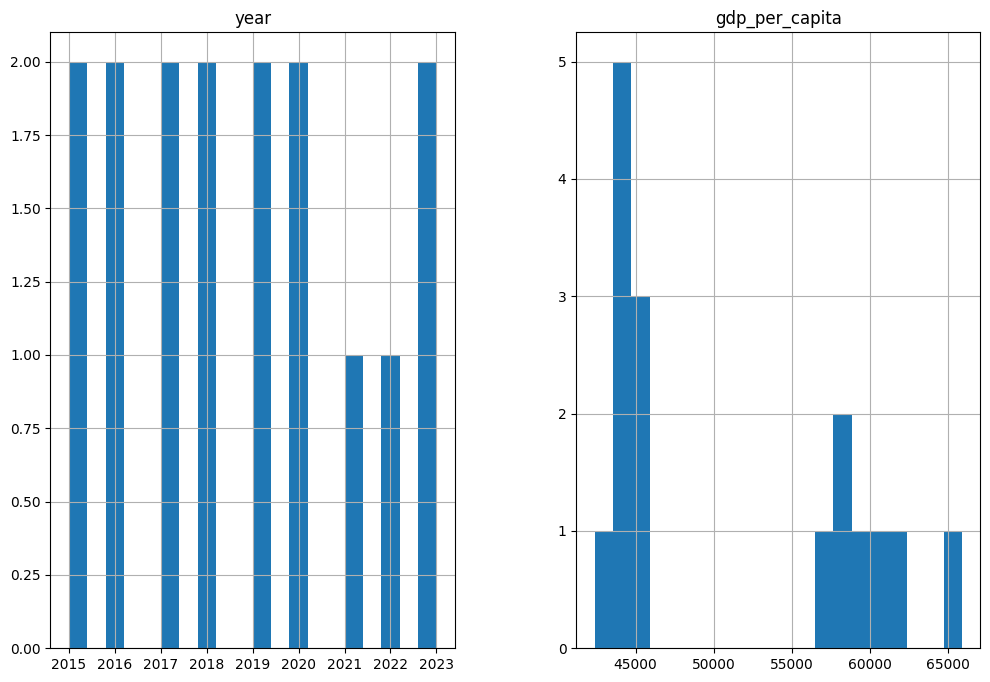

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Check for NaN values
print("Missing Values:\n", pd.DataFrame(X_train).isna().sum())

# Check for feature distribution
plt.figure(figsize=(12,6))
pd.DataFrame(X_train).hist(figsize=(12, 8), bins=20)
plt.show()


Part 4: Display the Models Overall Performance

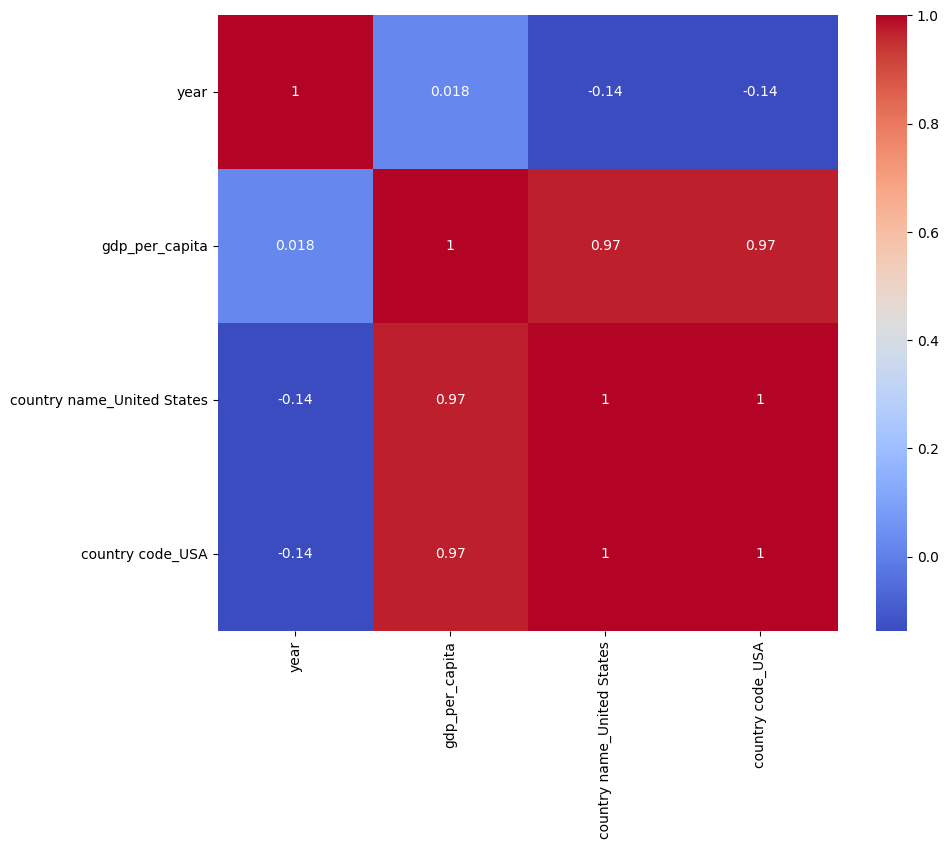

In [15]:
import seaborn as sns

corr_matrix = pd.DataFrame(X_train).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()


In [16]:
from scipy.stats import skew

skew_values = pd.DataFrame(X_train).apply(skew)
print("Feature Skewness:\n", skew_values)


Feature Skewness:
 year                          0.237696
gdp_per_capita                0.399001
country name_United States    0.251976
country code_USA              0.251976
dtype: float64


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

nn = Sequential([
    Dense(512, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),

    Dense(1)  # Output layer
])

nn.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

history = nn.fit(X_train_scaled, y_train,
                 validation_split=0.2,
                 epochs=1000,
                 batch_size=128,
                 callbacks=[early_stopping, lr_scheduler],
                 verbose=1)

y_pred_nn = nn.predict(X_test_scaled).flatten()
r2_nn = r2_score(y_test, y_pred_nn)

print(f"\n Model Performance - Neural Network \nR² Score: {r2_nn:.4f}")

if r2_nn >= 0.80:
    print("Neural Network meets performance target!")
else:
    print(" Neural Network needs further tuning.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 1624.5817 - mae: 37.9250 - val_loss: 1383.5691 - val_mae: 37.1409 - learning_rate: 5.0000e-04
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 1608.5840 - mae: 37.9200 - val_loss: 1383.5801 - val_mae: 37.1414 - learning_rate: 5.0000e-04
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 1589.8153 - mae: 37.9149 - val_loss: 1383.7644 - val_mae: 37.1442 - learning_rate: 5.0000e-04
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 1585.4600 - mae: 37.9099 - val_loss: 1383.7679 - val_mae: 37.1445 - learning_rate: 5.0000e-04
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 1578.1398 - mae: 37.9049 - val_loss: 1383.9910 - val_mae: 37.1479 - learning_rate: 5.0000e-04
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 1566.4883 - mae: 37.8998 - val_loss: 1383.9913 - val_mae: 37.1481 - learning_rate: 5.0000e-04
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step - loss: 1563.9420 - mae: 37

In [23]:
import csv

# Save model results in CSV
model_results = [
    ["Experiment", "Hidden Layer 1", "Hidden Layer 2", "Batch Size", "Epochs", "Validation Loss", "Test MAE", "R² Score"],
    [1, 80, 50, 16, len(history.history['loss']), min(history.history['val_loss']), mae, r2]
]

# Write to CSV
with open("WSC_Model.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(model_results)

print("WSC_Model.csv'")


WSC_Model.csv'
